# Read EBM data

In [2]:
import pandas as pd
import numpy as np


file_path = 'D:/VScode/EBM_NH_SH_sea_ice/EBM_data/'


# Replace these paths with the actual paths to your CSV files
nh_csv_file_path = file_path+'results_nh_n400_age0to200ka_20240208_0853.csv'
sh_csv_file_path = file_path+'results_sh_n400_age0to200ka_20240208_0853.csv'

# Read the CSV files
results_nh_df = pd.read_csv(nh_csv_file_path)
results_sh_df = pd.read_csv(sh_csv_file_path)

# rename columns to 'age' 'T' and 'iceA'
results_nh_df.columns = ['age', 'T', 'iceA']
results_sh_df.columns = ['age', 'T', 'iceA']

delta_age=0
# correct the age
results_nh_df['age'] = results_nh_df['age'] - delta_age
results_sh_df['age'] = results_sh_df['age'] - delta_age


# read the csv file
nh_plank = pd.read_csv('proxy_data/low_res_plank_d18O_1500kyr.csv')
# the first column is the age, the second column is the d18O
# age should/1000
nh_plank['age'] = nh_plank['age']/1000
# crop the data for age<=200
nh_plank = nh_plank[nh_plank['age']<=200]
# interpolate the data from 0 to 200 with 1 kyr interval
target_ages = np.arange(0, 201, 1)
interpolated_d18O = np.interp(target_ages, nh_plank.age.values, nh_plank.d18O.values)
nh_plank = pd.DataFrame({'age': target_ages, 'd18O': interpolated_d18O})

# nh_plank = nh_plank.set_index('age').reindex(age).interpolate().reset_index()

# # read the North Atlantic d18O
# # plot the data
# import matplotlib.pyplot as plt
# import numpy as np

# fig, ax = plt.subplots(1, 1, figsize=(12, 3))
# ax.plot(nh_plank['age'], -1*nh_plank['d18O'], 'b')
# ax.set_xlabel('age (years ago)')
# ax.set_ylabel('d18O (permil)')
# ax.set_title('planktonic')
# plt.subplots_adjust(hspace=0.5)
# plt.show()


# read D:\VScode\EBM_NH_SH_sea_ice\proxy_data\Wolff EW et al-2006-Nature-data2.xls
sh_ssna = pd.read_excel('proxy_data/Wolff EW et al-2006-Nature-data2.xls', sheet_name='caflux_2kyr', skiprows=4)
# delete the first row
sh_ssna = sh_ssna.drop(0)
# extract the first and forth column
sh_ssna = sh_ssna.iloc[:, [0, 3]]
# rename the column
sh_ssna.columns = ['age', 'ssna']
# remove columns with NaN
# Ensure 'age' and 'ssna' are numeric
sh_ssna['age'] = pd.to_numeric(sh_ssna['age'], errors='coerce')
sh_ssna['ssna'] = pd.to_numeric(sh_ssna['ssna'], errors='coerce')

# Optionally, remove rows where conversion to numeric failed and resulted in NaN
sh_ssna = sh_ssna.dropna(subset=['age', 'ssna'])
# crop the data for age<=200
sh_ssna = sh_ssna[sh_ssna['age']<=200]
# interpolate the data from 0 to 200 with 1 kyr interval
target_ages = np.arange(0, 201, 1)
interpolated_ssna = np.interp(target_ages, sh_ssna.age.values, sh_ssna.ssna.values)
sh_ssna = pd.DataFrame({'age': target_ages, 'ssna': interpolated_ssna})
sh_ssna



df_proxy_seaice_pc = pd.read_csv('proxy_data/Chadwick et al-2022_Stacks_PCA_pc.csv')
# get the first and second column
df_proxy_seaice_pc = df_proxy_seaice_pc.iloc[:, [0, 1]]
# rename the column
df_proxy_seaice_pc.columns = ['age', 'pc1']
# resample the data from 0 to 200 with 1 kyr interval
target_ages = np.arange(0, 150, 1)
interpolated_pc1 = np.interp(target_ages, df_proxy_seaice_pc.age.values, df_proxy_seaice_pc.pc1.values)
df_proxy_seaice_pc = pd.DataFrame({'age': target_ages, 'pc1': interpolated_pc1})
df_proxy_seaice_pc

,age,pc1
0,0,-0.294010
1,1,-0.364105
2,2,-0.434200
3,3,-0.558740
4,4,-0.683280
...,...,...
145,145,0.355135
146,146,0.350800
147,147,0.359245
148,148,0.367690


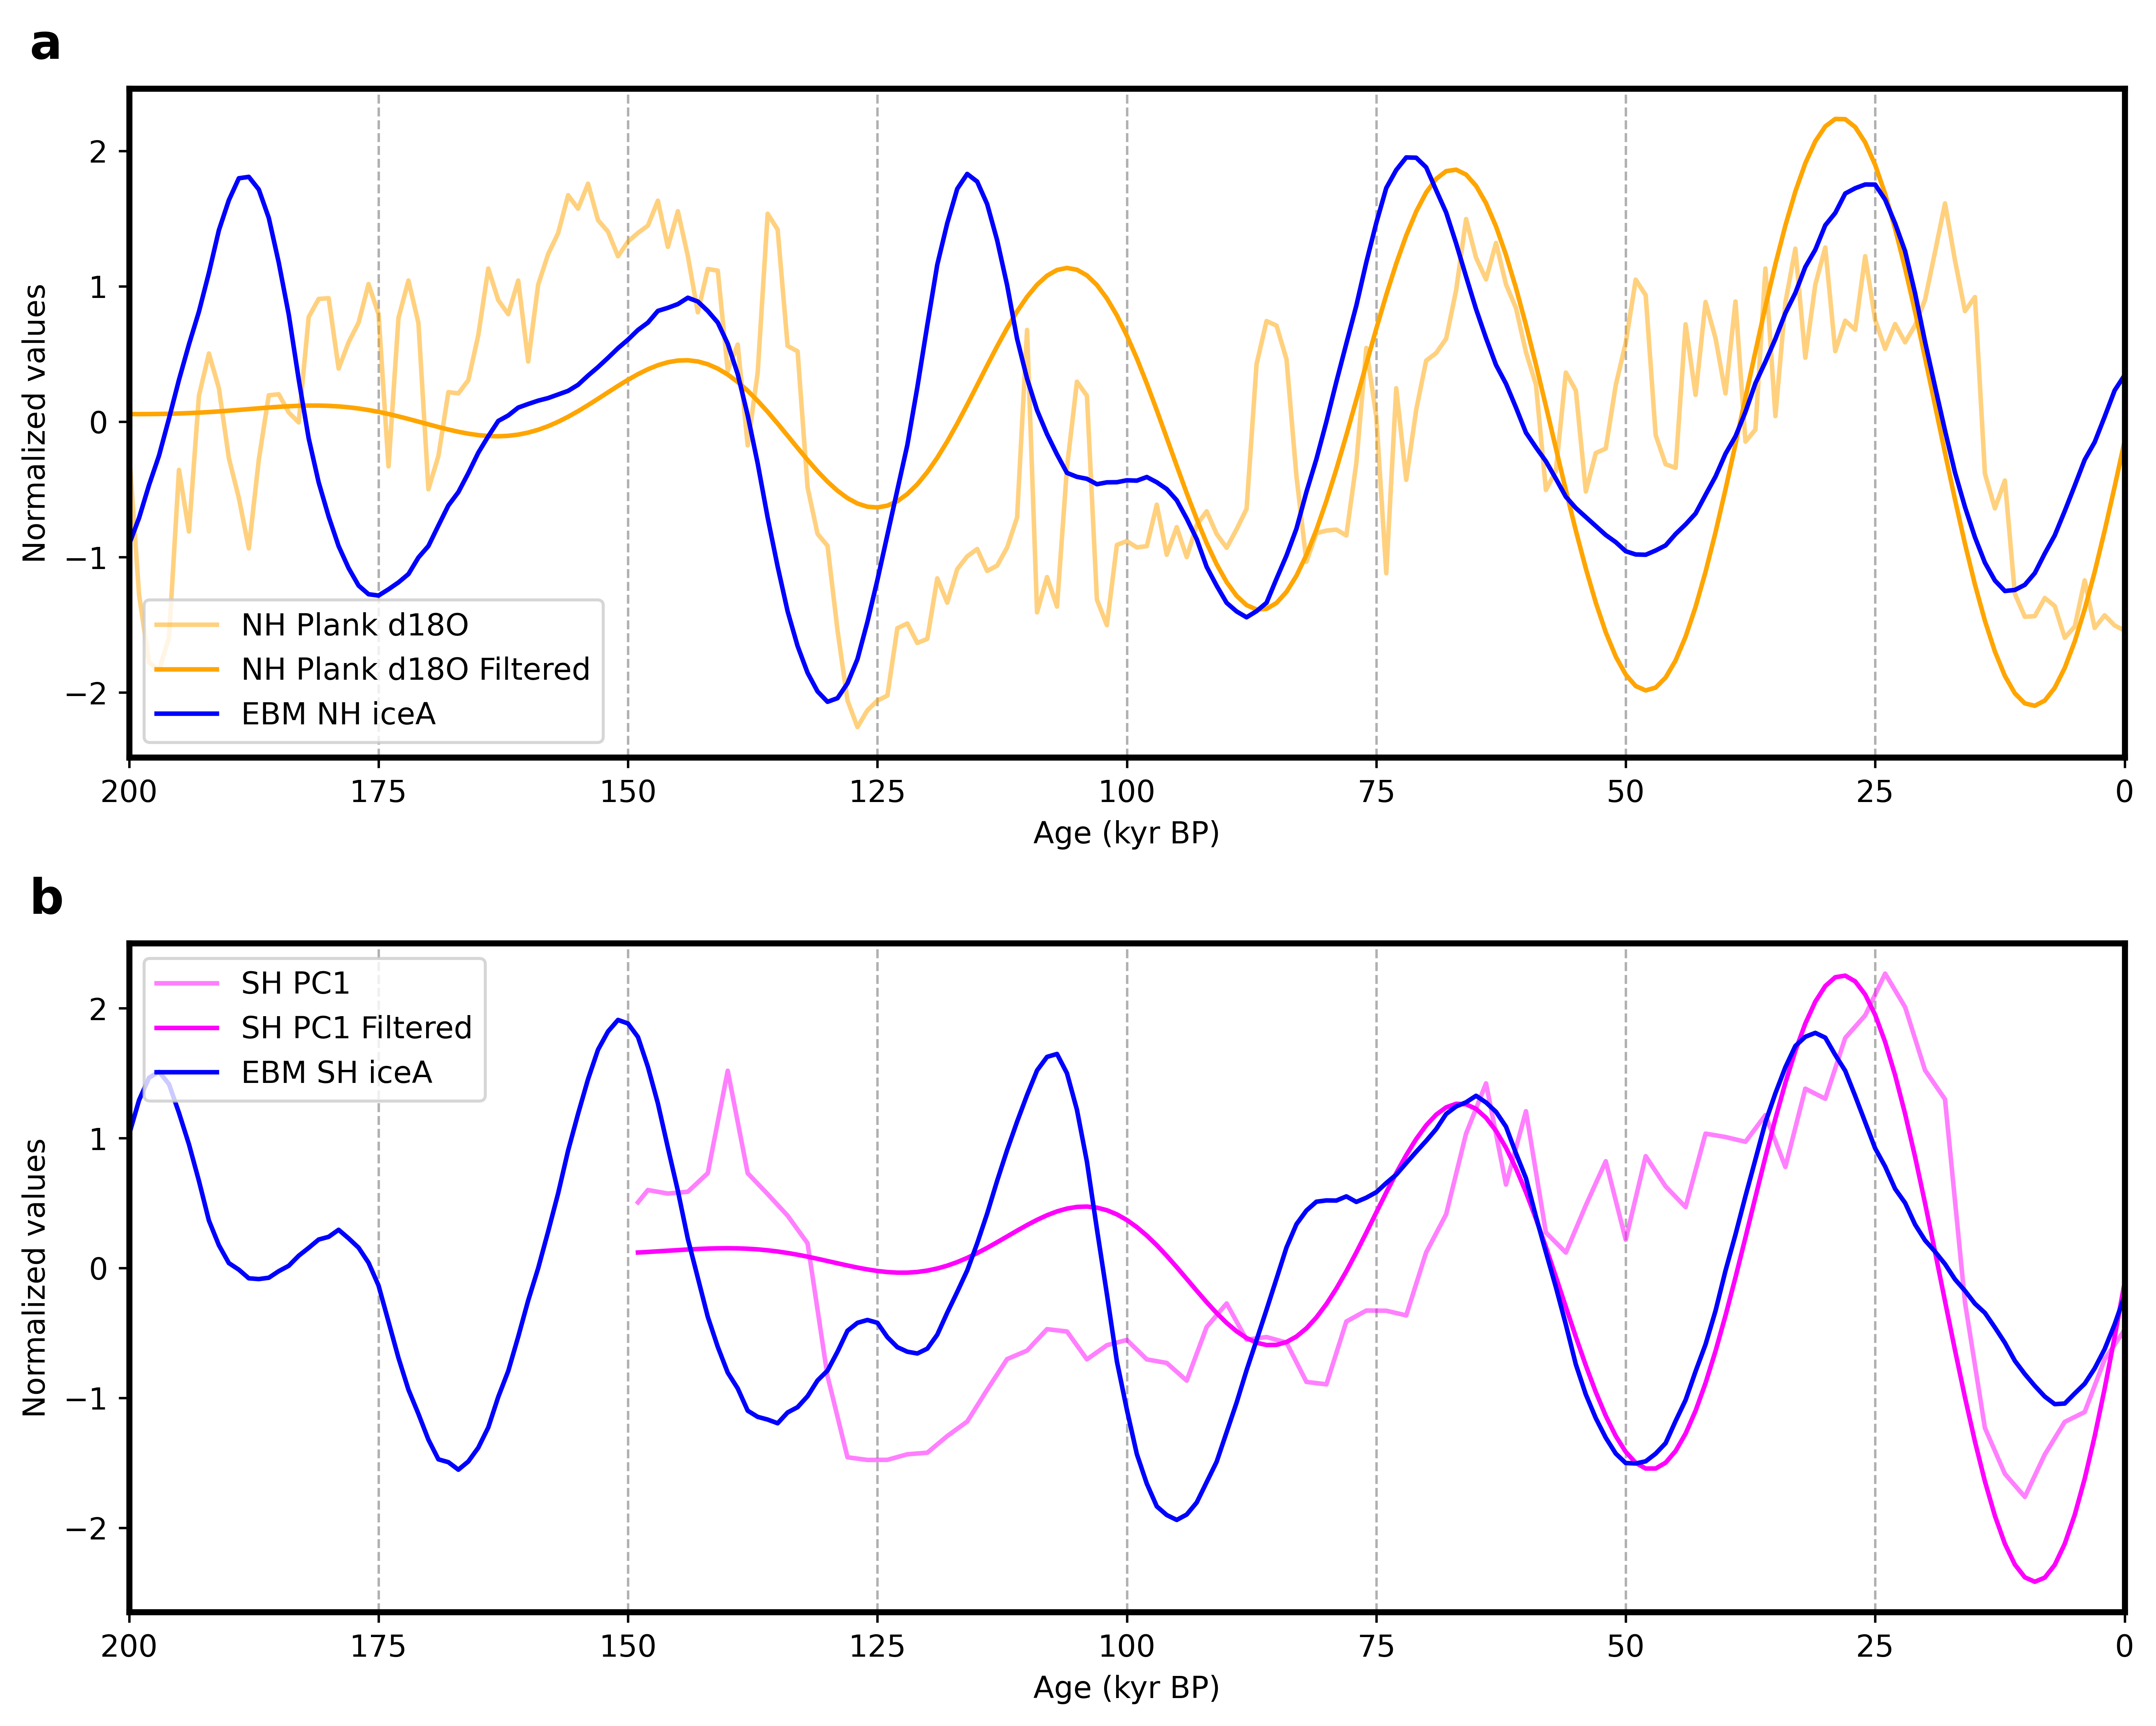

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import zscore
from scipy.signal import butter, filtfilt


fs = 1  # Sampling frequency, assuming one sample per thousand years
lowcut = 1/45
highcut = 1/35
b, a = butter(N=4, Wn=[lowcut, highcut], fs=fs, btype='band')

# Apply the filter to nh_plank and sh_ssna
nh_plank_filtered = filtfilt(b, a, -1*nh_plank['d18O'])
sh_ssna_filtered = filtfilt(b, a, sh_ssna['ssna'])
sh_pc1_filtered = filtfilt(b, a, df_proxy_seaice_pc['pc1'])

# Plotting
fig, axes = plt.subplots(2, 1, figsize=(10, 8),dpi=600)

# First row: NH data with normalized and filtered planktonic d18O
axes[0].plot(nh_plank['age'], zscore(nh_plank['d18O']), label='NH Plank d18O', color='orange',alpha=0.5)
axes[0].plot(nh_plank['age'], zscore(-nh_plank_filtered), label='NH Plank d18O Filtered', color='orange')
axes[0].plot(results_nh_df['age'], zscore(results_nh_df['iceA']), label='EBM NH iceA', color='blue')
axes[0].set_xlabel('Age (kyr BP)')
axes[0].set_ylabel('Normalized values')
# axes[0].set_title('Northern Hemisphere Sea Ice and Planktonic d18O (Normalized and Filtered)')
axes[0].legend()
# add vertical grid lines with linestyle '--'
axes[0].grid(axis='x', linestyle='--')
# set the linewidth of the box
for axis in ['top','bottom','left','right']:
    axes[0].spines[axis].set_linewidth(2)

# Second row: SH data with normalized and filtered ssna
# axes[1].plot(sh_ssna['age'], zscore(sh_ssna['ssna']), label='SH ssNa', color='magenta',alpha=0.5)
# axes[1].plot(sh_ssna['age'], zscore(sh_ssna_filtered), label='SH ssNa Filtered', color='magenta')
axes[1].plot(df_proxy_seaice_pc['age'], zscore(df_proxy_seaice_pc['pc1']), label='SH PC1', color='magenta',alpha=0.5)
axes[1].plot(df_proxy_seaice_pc['age'], zscore(sh_pc1_filtered), label='SH PC1 Filtered', color='magenta')
axes[1].plot(results_sh_df['age'], zscore(results_sh_df['iceA']), label='EBM SH iceA', color='b')
axes[1].set_xlabel('Age (kyr BP)')
axes[1].set_ylabel('Normalized values')
# axes[1].set_title('Southern Hemisphere Sea Ice and SSNA (Normalized and Filtered)')
axes[1].legend()
# add vertical grid lines with linestyle '--'
axes[1].grid(axis='x', linestyle='--')
# set the linewidth of the box
for axis in ['top','bottom','left','right']:
    axes[1].spines[axis].set_linewidth(2)

# set x lim to be 0 to 200
axes[0].set_xlim(200,0)
axes[1].set_xlim(200,0)

# add text a, b to the plot
axes[0].text(-0.05, 1.1, 'a', transform=axes[0].transAxes, fontsize=16, fontweight='bold', va='top')
axes[1].text(-0.05, 1.1, 'b', transform=axes[1].transAxes, fontsize=16, fontweight='bold', va='top')

plt.tight_layout()
plt.show()

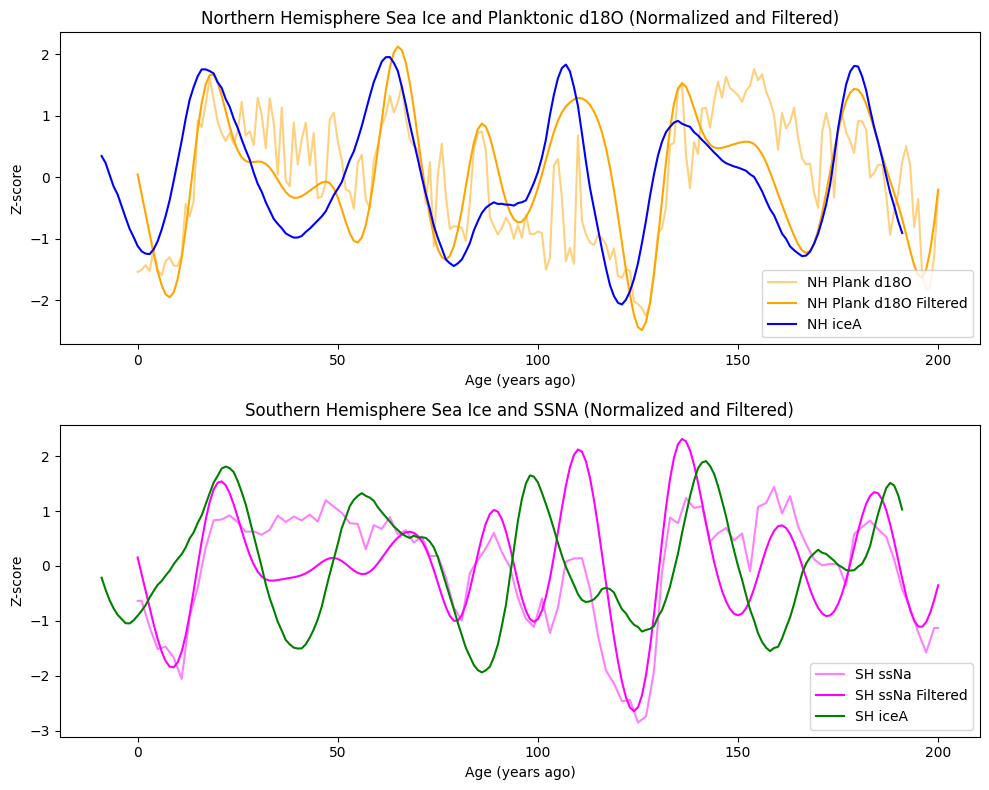

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import zscore
from scipy.signal import butter, filtfilt


fs = 1  # Sampling frequency, assuming one sample per thousand years
lowcut = 1/45
highcut = 1/15
b, a = butter(N=2, Wn=[lowcut, highcut], fs=fs, btype='band')

# Apply the filter to nh_plank and sh_ssna
nh_plank_filtered = filtfilt(b, a, -1*nh_plank['d18O'])
sh_ssna_filtered = filtfilt(b, a, sh_ssna['ssna'])

# Plotting
fig, axes = plt.subplots(2, 1, figsize=(10, 8))

# First row: NH data with normalized and filtered planktonic d18O
axes[0].plot(nh_plank['age'], zscore(nh_plank['d18O']), label='NH Plank d18O', color='orange',alpha=0.5)
axes[0].plot(nh_plank['age'], zscore(-nh_plank_filtered), label='NH Plank d18O Filtered', color='orange')
axes[0].plot(results_nh_df['age'], zscore(results_nh_df['iceA']), label='NH iceA', color='blue')
axes[0].set_xlabel('Age (years ago)')
axes[0].set_ylabel('Z-score')
axes[0].set_title('Northern Hemisphere Sea Ice and Planktonic d18O (Normalized and Filtered)')
axes[0].legend()

# Second row: SH data with normalized and filtered ssna
axes[1].plot(sh_ssna['age'], zscore(sh_ssna['ssna']), label='SH ssNa', color='magenta',alpha=0.5)
axes[1].plot(sh_ssna['age'], zscore(sh_ssna_filtered), label='SH ssNa Filtered', color='magenta')
axes[1].plot(results_sh_df['age'], zscore(results_sh_df['iceA']), label='SH iceA', color='green')
axes[1].set_xlabel('Age (years ago)')
axes[1].set_ylabel('Z-score')
axes[1].set_title('Southern Hemisphere Sea Ice and SSNA (Normalized and Filtered)')
axes[1].legend()

plt.tight_layout()
plt.show()